In [1]:
import time
import threading

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg

import pandas as pd
import pandas_datareader.data as web

In [2]:
from sklearn import linear_model
import pandas as pd

In [3]:
d=2 
M=150

def nilpotent(M):
    B = np.zeros((M,M))
    for i in range(2,M):
        B[i,i-1]=1.0
    return B

def canonical(i,M):
    e = np.zeros((M,1))
    e[i,0]=1.0
    return e

def vectorfieldSABR(state,increment):
    return np.array([(np.sqrt(state[0]**2))**0.7*np.exp(-0.5*state[1]),0.1])*increment[0]+np.array([0,0.25*(state[0]+state[1])])*increment[1]

def vectorfield2d(state,increment):
    return np.array([(2.0*np.sqrt(state[1]**2))**0.7+np.sin(state[1]),1.0*state[1]+np.cos(state[1])])*increment[0]+np.array([(2.0*np.sqrt(state[1]**2))**0.7,0.0*state[1]])*increment[1]

def randomAbeta(d,M):
    A = []
    beta = []
    for i in range(d):
        B = 0.0*nilpotent(M) + np.random.normal(0.0,0.03,size=(M,M))
        B = np.random.permutation(B)
        A = A + [B]
        beta = beta + [0.0*canonical(i,M)+np.random.normal(0.0,0.03,size=(M,1))]
    return [A,beta]

In [4]:
Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

def sigmoid(x):
    return np.tanh(x)

def reservoirfield(state,increment):
    value = np.zeros((M,1))
    for i in range(d):
        value = value + sigmoid(np.matmul(A[i],state) + beta[i])*increment[i]
    return value

In [5]:
class SDE:
    def __init__(self,timehorizon,initialvalue,dimension,dimensionBM,dimensionR,vectorfield,timesteps):
        self.timehorizon = timehorizon
        self.initialvalue = initialvalue # np array
        self.dimension = dimension
        self.dimensionBM = dimensionBM
        self.dimensionR = dimensionR
        self.vectorfield = vectorfield
        self.timesteps = timesteps

    def path(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]
        for i in range(self.timesteps):
            helper = np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def anypath(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]#[np.ones((self.dimension,1))*self.initialvalue]

        for i in range(self.timesteps):
            helper = np.cos(BMpath[-1]*50)*self.timehorizon/self.timesteps#np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def reservoir(self,BMpath,scaling,k,moving_time):
        reservoirpath = [canonical(k,self.dimensionR)*self.initialvalue]
        for i in range(moving_time-1):
            increment = scaling*(BMpath[i+1]-BMpath[i])
            reservoirpath = reservoirpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(reservoirpath[-1]+reservoirfield(reservoirpath[-1],increment))]
        return reservoirpath

In [6]:
Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

#### Generate stock prices

In [7]:
# Number of seconds/hours in one trading day: 9.30-16.30
sec = 10000 #25200
min = 420

In [8]:
SDE_of_interest = SDE(7,1.0,2,d,M,vectorfield2d,sec)
#SDE_of_interest = SDE(7,1.0,2,d,M,vectorfieldSABR,10000)
training = SDE_of_interest.path()

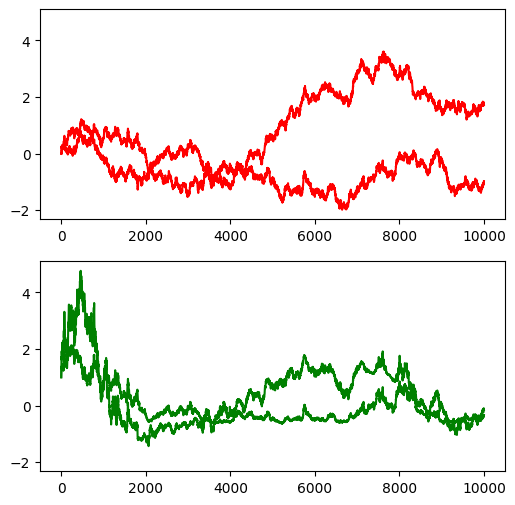

In [9]:
f1,p1=plt.subplots(2,1,figsize=(6,6),sharey=True)
p1[0].plot(training[0],'r')
p1[1].plot(training[1],'g')
#plt.savefig('trainingpath.pdf')
plt.show()

In [10]:
available_SDE_data_list = []
available_BM_data_list = []

available_BM_data = training[0][0]
available_SDE_data = training[1][0]

In [ ]:
print(type(training[0][0]))

In [ ]:
print(len(training[0]))

In [ ]:
"""train = False

def read_data_line_by_line(data_SDE, data_BM):
    global available_BM_data
    global available_SDE_data
    global train
    
    for i in range(1, len(training[0])): # len of list
        print(np.shape(available_BM_data))
        print(np.shape(available_SDE_data))

        available_BM_data_list.append(data_BM[i])
        available_SDE_data_list.append(data_SDE[i])

        available_BM_data = np.array(available_BM_data_list)
        available_SDE_data = np.array(available_SDE_data_list)

        if i % 10 == 0:
            train = True
        else: 
            train = False

        time.sleep(1) 


def train_model():
    global available_BM_data
    global available_SDE_data
    global train

    while train:
        if (len(available_SDE_data) % 10) == 0: 

            X = SDE_of_interest.reservoir(available_BM_data,1,0, len(available_SDE_data)) 
            Xtrain = np.squeeze(X) 

            Ytrain = np.squeeze(available_SDE_data) 

            lm = linear_model.Ridge(alpha=0.05)
            model = lm.fit(Xtrain, Ytrain)
            plt.plot(model.predict(Xtrain),'r')
            plt.plot(Ytrain,'b')
            plt.show()
            model.score(Xtrain,Ytrain)
            model.coef_

            print("Model trained successfully")

# Start the data reading thread
data_thread = threading.Thread(target=read_data_line_by_line, args=(training[1], training[0]))
data_thread.start()

# Start the model training thread
train_thread = threading.Thread(target=train_model)
train_thread.start()

# Join threads to ensure they complete (in a real scenario, you may not need to join if you want continuous execution)
data_thread.join()
train_thread.join()"""

In [ ]:
train_lock = threading.Lock()

def read_data(data_BM, data_SDE):
    global available_BM_data
    global available_SDE_data

    for i in range(1, len(data_BM)):

        available_BM_data_list.append(data_BM[i])
        available_SDE_data_list.append(data_SDE[i])

        available_BM_data = np.array(available_BM_data_list)
        available_SDE_data = np.array(available_SDE_data_list)
        time.sleep(1)  # Simulating the 1-second interval
        
        # Check if we need to train/retrain the model
        if len(available_SDE_data_list) % 20 == 0:
            threading.Thread(target=train_model).start()

def train_model():
    global model
    with train_lock:
        # Wait until there are at least 20 elements
        #while len(available_elements) < 20:
        #    time.sleep(0.1)
        
        # Train the model with the available data
        X = SDE_of_interest.reservoir(available_BM_data,1,0, len(available_SDE_data)) 
        Xtrain = np.squeeze(X) 

        Ytrain = np.squeeze(available_SDE_data) 

        lm = linear_model.Ridge(alpha=0.05)
        model = lm.fit(Xtrain, Ytrain)
        
        len_predict = len(available_BM_data) + 20 # predict 20 timesteps into the future
        X_pred = training[0][:len_predict]
        X_pred = np.squeeze(X_pred)
        plt.plot(model.predict(X_pred),'r')
        plt.plot(Ytrain,'b')
        plt.show()
        #model.score(Xtrain,Ytrain)
        #model.coef_

In [ ]:
# Start the data reading thread
data_thread = threading.Thread(target=read_data, args=(training[0], training[1]))
data_thread.start()
data_thread.join()

print("All data read. Final available elements:")
print(available_SDE_data)

I have the following problem. For the moment I have a brownian motion on a fixed time interval [a, b]. The I train my model on some interval [a, c] with c < a. After this I can predict the stock price on [c, b] but for this I need the brownian motion (and then the reservoir) on [c, b] first. But this I don't have in real time analysis, since I can only calculate the underlying brownian motion once I have the SDE path. Solutions:\

1) I can use a random brownian motion and then see how my model learns. This does not work very well...

2) Using the same method, I could learn the relation f(SDE[:t]) -> SDE[t:t+alpha]. I don't think that this works very well since we try to learn the output of a SDE when inputting a Brownian motion. So if we input the SDE this does not make much sence.

3) Or starting with an uncomplete (exponential) brownian motion can I predict it in the future? If yes can I learn this relation

I need to predict the rest of the past of the Brownian motion first and then I can apply the above. I don't need data every seecond. What I need to do:
1) Take the SDE as input which continues to evolve with time
2) Find the underlying BM (see code of Josed with Yfinance)
3) Predict an approximation of the future BM
4) Compare the real underlying BM with the one from step 1 and then compare the future of the real underlying BM with the future predicted in step 3.

## TESTING

In [ ]:
test = [val[0] for val in training[0][:50]]
print(test)
print(type(np.diff(test)))

In [11]:
n = 5000
BM_test = training[0][:n] #[val[0] for val in training[0][:50]]
increments = []

In [ ]:
print(np.shape(BM_test))
print(np.shape(training[0]))

In [12]:
for i in range(n-1):
    increments.append(BM_test[i+1]-BM_test[i])

In [ ]:
print(np.shape(increments))

In [13]:
np.random.seed(0)

t = 5000
dt = 1

#increments = np.diff(BM_test)
mu1 = np.mean([val[0] for val in increments]) / dt
sigma1 = np.std([val[0] for val in increments]) / np.sqrt(dt)

print(f"Estimated mu: {mu1}")
print(f"Estimated sigma: {sigma1}")

mu2 = np.mean([val[1] for val in increments]) / dt
sigma2 = np.std([val[1] for val in increments]) / np.sqrt(dt)

print(f"Estimated mu: {mu2}")
print(f"Estimated sigma: {sigma2}")

n_future = 5000

Estimated mu: -0.00017829641973038577
Estimated sigma: 0.02624132727276394
Estimated mu: 9.462472536765133e-05
Estimated sigma: 0.026618685123483185


In [14]:
mu = np.array([mu1, mu2])
sigma = np.array([sigma1, sigma2])

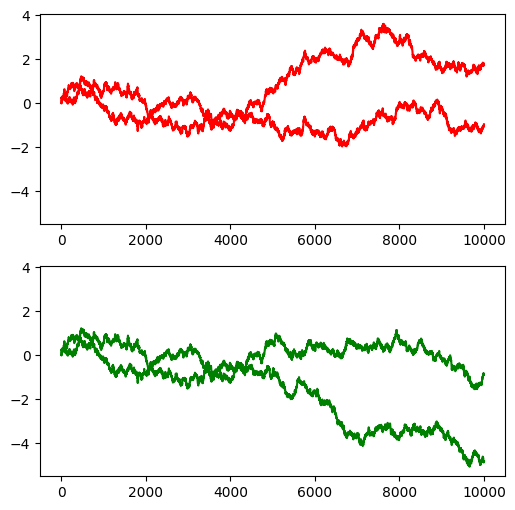

In [15]:
future_increments = np.sqrt(dt) * np.random.randn(n_future,2)

B_future = [BM_test[-1] + mu * dt + sigma * future_increments[0]]
for i in range(1, n_future):
    B_future.append(B_future[i-1] + mu * dt + sigma * future_increments[i])

BM_combined = np.concatenate((BM_test, B_future))

f2,p2=plt.subplots(2,1,figsize=(6,6),sharey=True)
p2[0].plot(training[0],'r')
p2[1].plot(BM_combined,'g')
plt.show()

In [16]:
Y = training[1]
Ydata = np.squeeze(Y)
Ytrain = Ydata[:7500]

In [ ]:
print(np.shape(Ytrain))

In [17]:
X1=SDE_of_interest.reservoir(training[0],1,0,10000) 
X2=SDE_of_interest.reservoir(BM_combined,1,0,10000) 

Xdata1 = np.squeeze(X1)
Xdata2 = np.squeeze(X2)

Xtrain1 = Xdata1[:7500]
Xtrain2 = Xdata2[:7500]

In [ ]:
print(np.shape(Xdata1[100:]))

In [ ]:
print(np.shape(Xtrain1))

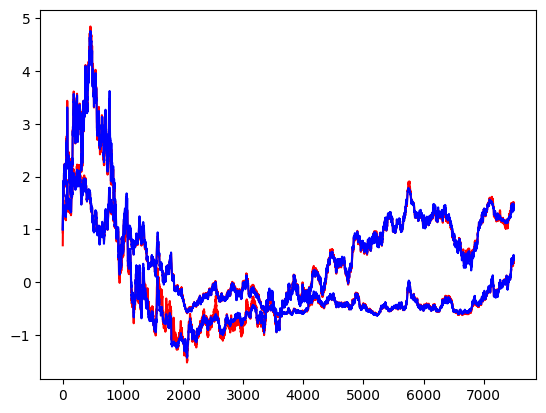

array([[ 4.79555236e-01,  1.83938202e-01,  6.53078179e-01,
        -1.91810695e+00, -2.12463974e+00,  9.21092247e-01,
         2.05894803e-02,  1.37457563e+00, -6.64027752e-02,
         8.24489637e-01,  8.25548323e-01, -2.35481564e-02,
        -3.15635035e-01,  9.44318113e-01,  5.50848308e-01,
        -1.29804877e+00,  1.61596541e+00,  1.57339250e+00,
        -2.17212108e-01, -6.33553919e-01, -3.59531536e-01,
        -2.44623116e+00,  1.34027586e+00, -1.17249718e+00,
         2.15036578e+00,  8.52526402e-01, -7.80853202e-01,
        -2.81439004e-01,  2.55480810e-01,  3.68486290e+00,
         5.66832642e-01, -1.73789429e+00,  9.03069419e-01,
         5.65976241e-01,  1.18793062e+00,  7.72461805e-01,
        -1.66712499e+00, -3.39208533e+00,  1.81109232e+00,
        -3.34949749e-01, -1.06871160e+00, -2.19497418e-01,
        -3.40302830e-01,  1.26203495e+00, -8.23710228e-01,
        -1.08783437e+00,  1.02741119e+00, -9.07762627e-01,
        -2.78572909e-02,  5.61463456e-01, -1.69596648e+0

In [18]:
lm = linear_model.Ridge(alpha=0.05)#
model = lm.fit(Xtrain1,Ytrain)
plt.plot(model.predict(Xtrain1),'r')
plt.plot(Ytrain,'b')
plt.show()
model.score(Xtrain1,Ytrain)
model.coef_

In [ ]:
print(np.shape(training[0]))

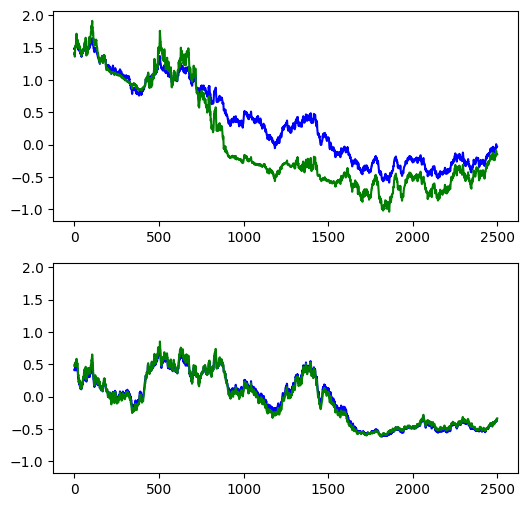

In [19]:
f,p=plt.subplots(2,1,figsize=(6,6),sharey=True)

N=2

for i in range(N):
    p[i].plot(model.predict(Xdata1[7500:])[:,i],'b')
    p[i].plot(Ydata[7500:][:,i],'g')
#plt.savefig('training.pdf')
plt.show()

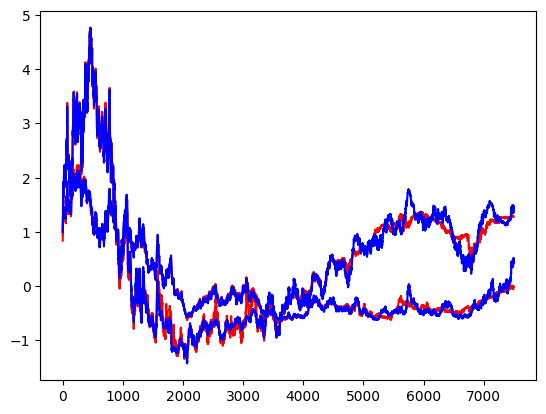

array([[ 0.19574935,  0.74886256, -0.71780558, -0.01973266,  0.26106079,
        -1.34643986, -2.99043796, -0.71656927, -1.27346069, -2.02259374,
        -1.6536438 , -0.52387607,  2.62496825,  0.7760522 , -1.82571189,
        -0.57085181,  2.72730391, -1.44805594, -3.65859154,  2.49297302,
        -3.05232181, -2.21321243,  2.38687098, -4.32555562, -0.76011554,
        -0.37537446, -1.5201745 , -3.07030114, -0.35345318, 10.29764963,
         2.3044114 , -1.51632342, -0.3087883 ,  3.82241831,  0.61572583,
        -2.67554003,  1.54452132,  1.17260943,  2.69694722,  2.63032217,
        -0.3871959 ,  0.910618  , -1.52829114, -0.04980144,  2.10854062,
        -1.59678132,  1.00464838, -0.01641747, -1.568969  ,  0.49189134,
         3.43127125, -2.74227605, -4.30192487,  2.71863122, -1.51434269,
         1.1884943 , -4.36907449,  2.42233009, -2.73109164, -1.87895943,
         1.58789704, -0.30442262, -4.2431562 , -1.01425557, -0.44572539,
         1.88635249,  0.20701724,  0.64649421, -2.3

In [20]:
lm2 = linear_model.Ridge(alpha=0.05)#
model = lm.fit(Xtrain2,Ytrain)
plt.plot(model.predict(Xtrain2),'r')
plt.plot(Ytrain,'b')
plt.show()
model.score(Xtrain2,Ytrain)
model.coef_

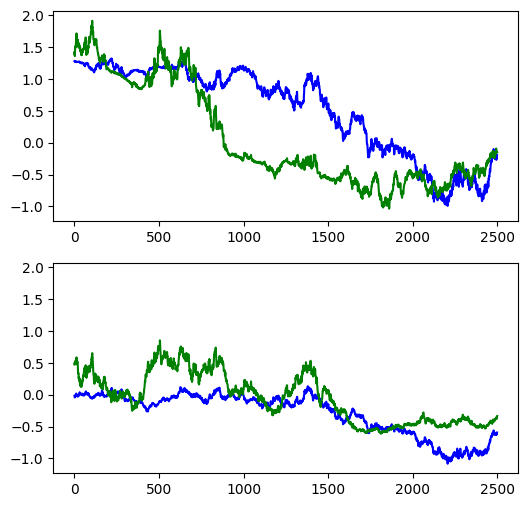

In [21]:
f2,p2=plt.subplots(2,1,figsize=(6,6),sharey=True)

N=2

for i in range(N):
    p2[i].plot(model.predict(Xdata2[7500:])[:,i],'b')
    p2[i].plot(Ydata[7500:][:,i],'g')
#plt.savefig('training.pdf')
plt.show()